In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../Pyfiles')
# Pull in the helper files.
from ImageRead import *
from QNN import *


In [2]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

In [3]:
pathY=r'../dataset/Original/galaxy/'
pathN=r'../dataset/Original/No-galaxy/'
nameN=''
nameY=''
# a1 = imageResize(callImage(5,pathY,nameY),16)
# a2 = imageResize(callImage(29,pathY,nameY),16)
# # plt.imshow(a1,cmap='gray')
# plt.imshow(a2,cmap='gray')
# plt.imshow(b1,cmap='gray')
# plt.imshow(b2,cmap='gray')
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

In [4]:
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

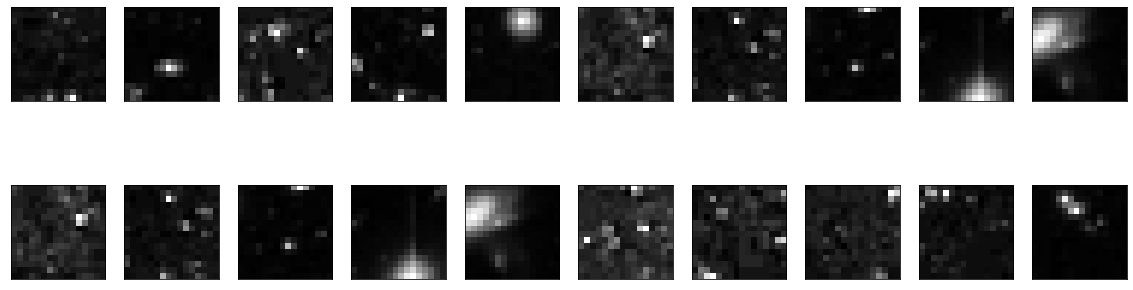

In [5]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(n_samples_show):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    


In [6]:
from qiskit.circuit.parameter import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=256
qc = QuantumCircuit(nqubits)

# Encoding
param_x=[];
for i in range(num_inputs):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)


feature_map = encoding(qc,param_x,22)


# Optimzing circuit PQC
param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qc,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


# Learning Rate 0.05

In [7]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [8]:
from torch import Tensor
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [9]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [10]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.108192443847656
32.4072380065918
32.03237533569336
31.895145416259766
31.78937530517578
31.689733505249023
31.59193229675293
31.493995666503906
31.396451950073242
31.304031372070312
31.22391700744629
31.15971565246582
31.109495162963867
31.069421768188477
31.036239624023438
31.007585525512695
30.98176383972168
30.957427978515625
30.93332862854004
30.908166885375977
30.88027572631836
30.84713363647461
30.804162979125977
30.741378784179688
30.637073516845703
30.515186309814453
30.469327926635742
30.444242477416992
30.421152114868164
30.39798355102539
30.37508773803711
30.352642059326172
30.330595016479492
30.308734893798828
30.286935806274414
30.26512908935547
30.24332046508789
30.221588134765625
30.200000762939453


tensor(30.9082, grad_fn=<AddBackward0>)

In [11]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


# Learning rate 0.06

In [12]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.06)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [13]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.092506408691406
32.27847671508789
31.932584762573242
31.801755905151367
31.696422576904297
31.596323013305664
31.49781036376953
31.399715423583984
31.304540634155273
31.219013214111328
31.14921760559082
31.095157623291016
31.052919387817383
31.01851463317871
30.989017486572266
30.96230697631836
30.936681747436523
30.910457611083984
30.88165283203125
30.847291946411133
30.801864624023438
30.7325382232666
30.610553741455078
30.497982025146484
30.462387084960938
30.439420700073242
30.41527557373047
30.38955307006836
30.363304138183594
30.336950302124023
30.31045150756836
30.28369903564453
30.256694793701172
30.22960662841797
30.202392578125
30.172588348388672
30.144634246826172
30.120256423950195
30.096738815307617


tensor(30.8473, grad_fn=<AddBackward0>)

In [14]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


# Learning Rate 0.07

In [15]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.07)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [16]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.07685089111328
32.15932846069336
31.843116760253906
31.71990394592285
31.616920471191406
31.518083572387695
31.42047691345215
31.324111938476562
31.233501434326172
31.156253814697266
31.095962524414062
31.04983901977539
31.013206481933594
30.98231315612793
30.954456329345703
30.927480697631836
30.899188995361328
30.866764068603516
30.82535743713379
30.764251708984375
30.654775619506836
30.505294799804688
30.467437744140625
30.445926666259766
30.420310974121094
30.390424728393555
30.358802795410156
30.326568603515625
30.2938232421875
30.260597229003906
30.227100372314453
30.19232749938965
30.15595245361328
30.12395477294922
30.094696044921875
30.066675186157227
30.039791107177734
30.01435661315918
29.9906005859375


tensor(30.7643, grad_fn=<AddBackward0>)

In [17]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


# TestModel2

In [18]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

pathY=r'../dataset/Original/galaxy1/'
pathN=r'../dataset/Original/no-galaxy1/'
nameN=''
nameY=''
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

Xtest= [normlaizeData(dataInput[i].flatten()) for i in range(25)]
y01test= [data_target_o[i] for i in range(25)]

Xtest1= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01test1= [data_target_o[i] for i in range(50)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy25data:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

y_predict1 = []
for x in Xtest1:
    output = model2(Tensor(x))
    y_predict1 += [np.argmax(output.detach().numpy())]

print('Accuracy50data:', sum(y_predict1 == np.array(y01test1))/len(np.array(y01test1)))

Accuracy25data: 0.84
Accuracy50data: 0.78
